## UMI-based single cell data

The dataset we are using in this tutorial is based on a microdroplet-based method from 10X chromium. From today's lecture we remember that the single cell sequencing protocol works as follow:

- each cell is isolated together with a barcode bead in a gel/oil droplet
- each transcript in the cell is captured via the bead and assigned a cell barcode and a transcript unique molecular identifier (UMI)
- 3' reverse transcription of mRNA into cDNA is then performed in preparation to the PCR amplification
- the cDNA is amplified through PCR cycles
- the resulting reads are ready to go through a dedicated pipeline for transcriptome alignment.

Let's look at a specific read and its UMI and cell barcode. The data is organized in paired-end reads (written on `fastq` files), where the first `fastq` file contains reads in the following format 

```
@SRR8363305.1 1 length=26
NTGAAGTGTTAAGACAAGCGTGAACT
+SRR8363305.1 1 length=26
#AAFFJJJJJJJJJJJJJJJJFJJJJ
```

Here, the first 16 characters `NTGAAGTGTTAAGACA` represent the cell barcode, while the last 10 characters `AGCGTGAACT` are the transcript UMI tag. The last line represents the quality scores of the 26 characters of barcode+UMI.

The associated second `fastq` file contains reads of 98nt as the following
```
@SRR8363305.1 1 length=98
NCTAAAGATCACACTAAGGCAACTCATGGAGGGGTCTTCAAAGACCTTGCAAGAAGTACTAACTATGGAGTATCGGCTAAGTCAANCNTGTATGAGAT
+SRR8363305.1 1 length=98
#A<77AFJJFAAAJJJ7-7-<7FJ-7----<77--7FAAA--<JFFF-7--7<<-F77---FF---7-7A-777777A-<-7---#-#A-7-7--7--
```
The 98nt-long string of characters in the second line is a partial sequence of the cDNA transcript. Specifically, the 10X chromium protocol used for sequencing the data is biased towards the 3' end, because the sequencing happens from the 3' to the 5' end of the transcripts. The last line contains the corresponding quality scores.

Once the data is sequenced, it is possible to align the reads to the transcriptome. This is done with tools that are sensible to the presence of spliced transcripts. We will skip the alignment step because it is quite trivial (it requires a pipeline implemented by 10X, where one has to prepare only the data folders), and because it would require too much memory for the resources we have available on Google Colab. Instead, we start from the transcript count matrix that results as the output from the transcriptome alignment.

## Install and import the packages necessary to run this python notebook
We will use *scanpy* as the main analysis tool for the analysis. Scanpy has a comprehensive [manual webpage](https://scanpy.readthedocs.io/en/stable/) that includes many different tutorial you can use for further practicing. Scanpy is used in the discussion paper and the tutorial paper of this course. 
An alternative and well-established tool for R users is [Seurat](https://satijalab.org/seurat/). However, scanpy is mainatined and updated by a wider community with many of the latest developed tools.

ignore all the messages you see when installing the various packages

In [1]:
!wget https://raw.githubusercontent.com/SamueleSoraggi/scRNA-tutorial/master/Environment/requirements.txt
#!pip install -r requirements.txt scanpy==1.7.2 seaborn==0.11.1 bbknn==1.4.0 leidenalg==0.8.4 palantir==1.0.0 matplotlib==3.4.2 annoy==1.17.0
!pip install -r requirements.txt

--2021-06-15 08:06:55--  https://raw.githubusercontent.com/SamueleSoraggi/scRNA-tutorial/master/Environment/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7201 (7.0K) [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]   7.03K  --.-KB/s    in 0s      

2021-06-15 08:06:55 (56.1 MB/s) - ‘requirements.txt’ saved [7201/7201]

     |████████████████████████████████| 133kB 14.1MB/s 
     |████████████████████████████████| 655kB 19.0MB/s 
     |████████████████████████████████| 153kB 19.4MB/s 
     |████████████████████████████████| 1.0MB 32.0MB/s 
     |████████████████████████████████| 153kB 34.1MB/s 
     |████████████████████████████████| 4.7MB 36.7MB/s 
     |████████████████████████████████| 153kB 42.9

In [ ]:
#restart the runtime of python to be able to import some of the installed packages
#this will make your notebook "crash", so that you can import packages in the
#desired version afterwards
import os
os.kill(os.getpid(), 9)

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import doubletdetection as dbd
import os

**Download datasets**

In [2]:
!wget https://github.com/SamueleSoraggi/scRNA-tutorial/blob/master/Data/testisGuo.h5ad.gz?raw=true -O testisGuo.h5ad.gz
if os.path.exists('testisGuo.h5ad.gz'):
  !gunzip testisGuo.h5ad.gz

--2021-06-15 08:09:33--  https://github.com/SamueleSoraggi/scRNA-tutorial/blob/master/Data/testisGuo.h5ad.gz?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SamueleSoraggi/scRNA-tutorial/raw/master/Data/testisGuo.h5ad.gz [following]
--2021-06-15 08:09:33--  https://github.com/SamueleSoraggi/scRNA-tutorial/raw/master/Data/testisGuo.h5ad.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SamueleSoraggi/scRNA-tutorial/master/Data/testisGuo.h5ad.gz [following]
--2021-06-15 08:09:34--  https://raw.githubusercontent.com/SamueleSoraggi/scRNA-tutorial/master/Data/testisGuo.h5ad.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.

##Loading and understanding the dataset

There are many different possible formats. Each format has a dedicated reading command in scanpy, for example `read_h5ad`, `read_10X` ....

In [3]:
adata = sc.read('./testisGuo.h5ad')

The data is opened and an `Annotated data` object is created. This object contains:


*   The data matrix `adata.X` of size $N\_cells \times N\_genes$
*   Vectors of cells-related variables in the dataframe `adata.obs`
* Vectors of genes-related variables in the dataframe `adata.var`
* Matrices of size $N\_cells \times N\_genes$ in `adata.layers`
* Matrices where each line is cell-related in `adata.obsm`
* Matrices where each line is gene-related in `adata.varm`
* Anything else that must be saved is in `adata.uns`

The cells are called observations (obs) and the genes variables (var).

![alt text](https://falexwolf.de/img/scanpy/anndata.svg)


In [4]:
adata

AnnData object with n_obs × n_vars = 2500 × 7500
    obs: 'batch'

We calculate quality measures to fill the object `adata` with some observations and variables

In [5]:
sc.preprocessing.calculate_qc_metrics(adata, inplace=True)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


We can see that now `adata` contains many observations (`obs`) and variables (`var`). Those can be used for filtering and analysis purpose, as well as they might be needed by some scanpy tools

In [6]:
adata

AnnData object with n_obs × n_vars = 2500 × 7500
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

`adata.obs` is a dataframe, i.e. a table with indexes on the rows (cell barcodes) and column names (the observation types). One can select a specific observation type by indexing it in the table

In [7]:
adata.obs

batch  ...  pct_counts_in_top_500_genes
CTGCTGTAGACCACGA-1-1  SAM_2  ...                   100.000000
ATTACTCCACGCCAGT-2-1  SAM_2  ...                   100.000000
CGTCTACCAAGACACG-2-2  SAM_3  ...                    76.729560
GCACATATCACCCTCA-2-1  SAM_2  ...                    94.330246
AGAGCGAAGTCGTACT-1-0  SAM_1  ...                   100.000000
...                     ...  ...                          ...
TCGTACCAGCTGGAAC-2-2  SAM_3  ...                    91.766545
CCGTTCAGTTCGGCAC-1-2  SAM_3  ...                   100.000000
GGGCACTTCGTGTAGT-2-2  SAM_3  ...                    73.532914
AACGTTGGTGATAAGT-1-2  SAM_3  ...                    73.996569
ACATCAGGTTACGTCA-2-0  SAM_1  ...                    95.540514

[2500 rows x 9 columns]

In [8]:
adata.obs['batch'] #sample label - the data contains three separate samples

CTGCTGTAGACCACGA-1-1    SAM_2
ATTACTCCACGCCAGT-2-1    SAM_2
CGTCTACCAAGACACG-2-2    SAM_3
GCACATATCACCCTCA-2-1    SAM_2
AGAGCGAAGTCGTACT-1-0    SAM_1
                        ...  
TCGTACCAGCTGGAAC-2-2    SAM_3
CCGTTCAGTTCGGCAC-1-2    SAM_3
GGGCACTTCGTGTAGT-2-2    SAM_3
AACGTTGGTGATAAGT-1-2    SAM_3
ACATCAGGTTACGTCA-2-0    SAM_1
Name: batch, Length: 2500, dtype: category
Categories (3, object): ['SAM_1', 'SAM_2', 'SAM_3']

`adata.var` works similarly, but now each row is referred to a gene

In [9]:
adata.var

n_cells_by_counts  mean_counts  ...  total_counts  log1p_total_counts
AP006222.2                   598     0.380000  ...         950.0            6.857514
RP11-206L10.9                669     0.701600  ...        1754.0            7.470224
FAM41C                       293     0.188000  ...         470.0            6.154858
SAMD11                       193     0.116800  ...         292.0            5.680172
HES4                         193     0.122400  ...         306.0            5.726848
...                          ...          ...  ...           ...                 ...
MT-ND3                      2414    82.879997  ...      207200.0           12.241445
AC136616.1                   369     0.242800  ...         607.0            6.410175
AC007325.1                    17     0.010800  ...          27.0            3.332205
AC023491.2                    67     0.157200  ...         393.0            5.976351
AC240274.1                   560     0.784400  ...        1961.0            7.581720

[7500 rows x 6 columns]

In [10]:
adata.var['n_cells_by_counts'] #nr of cells showing transcripts of a gene

AP006222.2        598
RP11-206L10.9     669
FAM41C            293
SAMD11            193
HES4              193
                 ... 
MT-ND3           2414
AC136616.1        369
AC007325.1         17
AC023491.2         67
AC240274.1        560
Name: n_cells_by_counts, Length: 7500, dtype: int64

##Preprocessing

We preprocess the dataset by filtering according to different quality measures and removing doublets

### Quality Filtering
Using the prefix `MT-` in the gene names we calculate the percentage of mithocondrial genes in each cell, and store this value as an observation in `adata.obs`. Cells with high MT percentage are often broken cells that spilled out mithocondrial content (in this case they will often have low gene and transcript counts), or cells captured together with residuals of broken cells (more unlikely if a good job in the sequencing lab has been done)

In [13]:
MT = ['MT-' in i for i in adata.var_names] #a vector with True and False to find MT genes

In [14]:
perc_mito = np.sum( adata[:,MT].X, 1 ).A1 / np.sum( adata.X, 1 ).A1
adata.obs['perc_mito'] = perc_mito.copy()

One can identify cells to be filtered out by looking at the relation between number of transcripts and number of genes per cell, coloured by percent of MT genes. Here, a possibility could be to exclude cells with >20000 transcripts, >2500 genes, <500 genes or >20% MT genes. Note that many cells with high MT percentage have a relatively low number of transcripts.

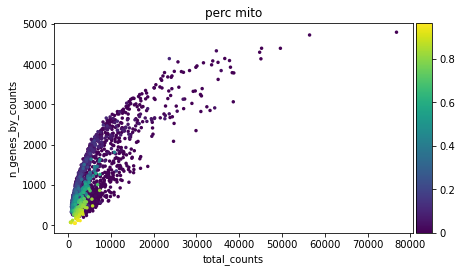

In [15]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='perc_mito')

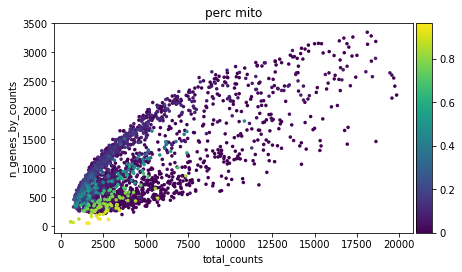

In [16]:
#same plot only looking at highest 20K transcripts per cell
sc.pl.scatter(adata[adata.obs['total_counts']<20000], x='total_counts', y='n_genes_by_counts', color='perc_mito')

Another useful visualization is the distribution of each quality feature of the data. Below we put also some lines for the threshold where we might want to filter.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Distribution of MT genes percentage per cell')

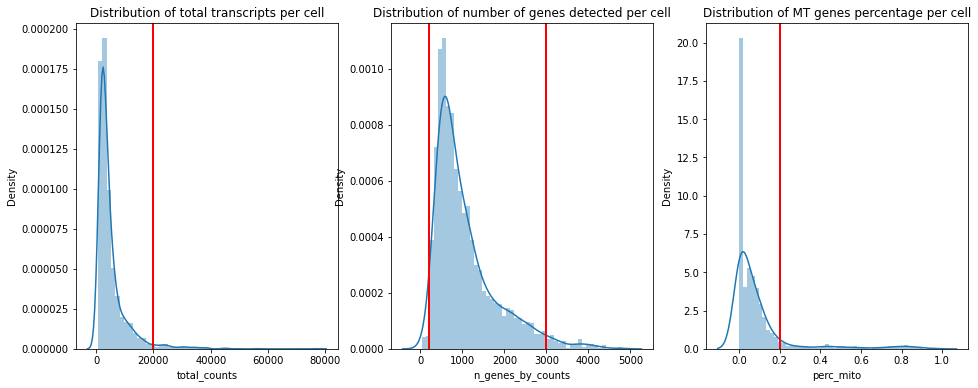

In [17]:
plt.rcParams['figure.figsize'] = (16,6)
f, ax = plt.subplots(1,3)

sns.distplot(adata.obs['total_counts'], ax=ax[0], bins=50)
ax[0].axvline(20000, color='red', linewidth=2)
ax[0].set_title('Distribution of total transcripts per cell')

sns.distplot(adata.obs['n_genes_by_counts'], ax=ax[1], bins=50)
ax[1].axvline(200, color='red', linewidth=2)
ax[1].axvline(3000, color='red', linewidth=2)
ax[1].set_title('Distribution of number of genes detected per cell')

sns.distplot(adata.obs['perc_mito'], ax=ax[2], bins=50)
ax[2].axvline(0.2, color='red', linewidth=2)
ax[2].set_title('Distribution of MT genes percentage per cell')

we use the following commands to implement the thresholds

In [18]:
sc.preprocessing.filter_cells(adata, max_genes=3000)

In [19]:
sc.preprocessing.filter_cells(adata, min_genes=200)

In [20]:
sc.preprocessing.filter_cells(adata, max_counts=20000)

In [21]:
adata = adata[adata.obs['perc_mito']<0.2].copy()

It is good practice to also remove those genes found in too few cells (for example in 5 or less cells). Any cell type clustering five or less cells will be not detected in the data, but in any case it would be irrelevant to have such tiny clusters.

In [22]:
sc.preprocessing.filter_genes(adata, min_cells=5)

In [23]:
print('There are now', adata.shape[0], 'cells and', adata.shape[1],'genes')

There are now 2154 cells and 7394 genes


### Doublets removal

We filter now doublets out of the dataset. To do this, we use the package `DoubleteDetector`, that simulates doublets from the dataset and looks for cells very similar to them. The algorithm runs with the following few steps.

In [24]:
#create the doublet identifier
clf = dbd.BoostClassifier(random_state=12345) 
# raw_counts are taken from the compressed data matrix in adata.X
X = np.array(adata.X.todense()).copy()
# predict doublets and save them in labels
labels = clf.fit( X ).predict()
# save also scores for doublets
scores = clf.doublet_score()

doublets labels are $1$ for cells that are identified as doublets, $0$ for normal cells and $nan$ for cells that are as likely to be one of the two types. We filter here the data.

In [29]:
n = np.shape( adata[ labels != 0 ] )
print( f'there are {n[0]} doublets or unidentified cells. {n[0]/adata.shape[0]*100}% of data')

there are 30 doublets or unidentified cells. 1.392757660167131% of data


In [30]:
adata = adata[ labels == 0 ].copy()

### Normalize the data

Biologically similar cells are not necessarily **directly comparable** in a dataset because of different technical biases, amongst many the different percentage of captured transcripts (capture efficiency), the presence of technical replicates, the presence of noisy transcripts. The capture efficiency can be influenced by many factors, i.e. the different transcript tags leading to different capture efficiency, the type of protocol used in the laboratory, the amount of PCR performed on different transcripts. Biological biases might as well alter the transcript proportion in a cell, for example in case of different points in the cell cycles altering the expression of specific genes.

To avoid these differences, a **normalization** approach is needed. Normalization is one of the main topics of scRNAseq data preprocessing, and many advanced techniques taking into account the statistical distribution of counts and the presence of technical/biological features of interest.

The most standard approach is the **TMP (Transcript Per Million) normalization**. Here, the transcripts is each cell are rescaled with the same factor, so that the transcripts in each cell sum to the same value. After TPM rescaling, the data is usually logarithmized, so that a transcript $x$ becomes $log(x+1)$. Logarithmization is known to help reducing the technical bias induced by the amount of transcripts in each cell. Finally, the data is standardized with mean 0 and variance 1. This is necessary since the PCA assumes implicitly that datapoints are normally distributed.

As a rule of thumb, TPM is not any longer consider a very good normalization technique. Instead, it is suggested to use more advanced methods for considering technical and biological covariates as part of a statistical model for the transcripts. One of the current state-of-the-art method is *scTransform*. This is implemented in `R`, but [a `python` package is coming](https://github.com/atarashansky/SCTransformPy).

During the various steps of normalization, logarithmization, and standardization, we save the data matrices in `adata.layers` for further use - this is useful if one needs a specific matrix for future calculations.

In [31]:
# save raw data matrix
adata.layers['raw_counts'] = adata.X.copy()

# TPM normalization and matrix copy
sc.pp.normalize_per_cell(adata)
adata.layers['tpm_counts'] = adata.X.copy()

# matrix logarithmization and copy
sc.pp.log1p(adata)
adata.layers['log_counts'] = adata.X.copy()

# standardized gene expressions and matrix copy
sc.pp.scale(adata)
adata.layers['gauss_counts'] = adata.X.copy()

##Dimensionality reduction

With the term **dimensionality reduction**, we intend the projection of each data point (cell) $x=[x_1, x_2, \dots, x_{N_{cell}}]$ into a data point $y$ in  $D$ dimensions, so that $y=[y_1, y_2, \dots, y_D]$, where $D << N_{cell}$.

![](https://blackboard.au.dk/bbcswebdav/pid-2693257-dt-content-rid-8808321_1/xid-8808321_1)

Dimensionality reduction is meaningful for single cell data analysis, since we know that the genes are expressed in modules of co-expression, meaning that the behaviour of many co-expressed genes can be compressed into the same dimension. 

Moreover, using computationally heavy algorithms on the reduced data will help speeding up calculations and reduce memory use, though using a reliable approximation of the full-dimension dataset. 

### PCA

PCA is one of the most used dimensionality reduction methods. It projects the data by identifying the axis of maximum variation. Since axis are orthogonal, PCA is best for data that has a linear behaviour. However, it has proved to be a reliable method for single cell data, especially to establish the PCA projection as the starting point for computational methods.

![](https://blackboard.au.dk/bbcswebdav/pid-2693259-dt-content-rid-8808322_1/xid-8808322_1)

In [32]:
## select some of the most variable genes in the data. 
## this is not used here, because the data has already 
## a limited amount of genes
#sc.preprocessing.highly_variable_genes(adata)

In [33]:
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)

In [34]:
adata

AnnData object with n_obs × n_vars = 2124 × 7394
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_mito', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'tpm_counts', 'log_counts', 'gauss_counts'

You can visualize the ratio of variances of the PCA axis, where you can see which number of dimensions is best to consider for further applications. Low variance ratios illustrate that along those axis the data contains little information, and probably mostly backgound noise of the dataset. Here we can for example choose between 10 and 15 dimensions

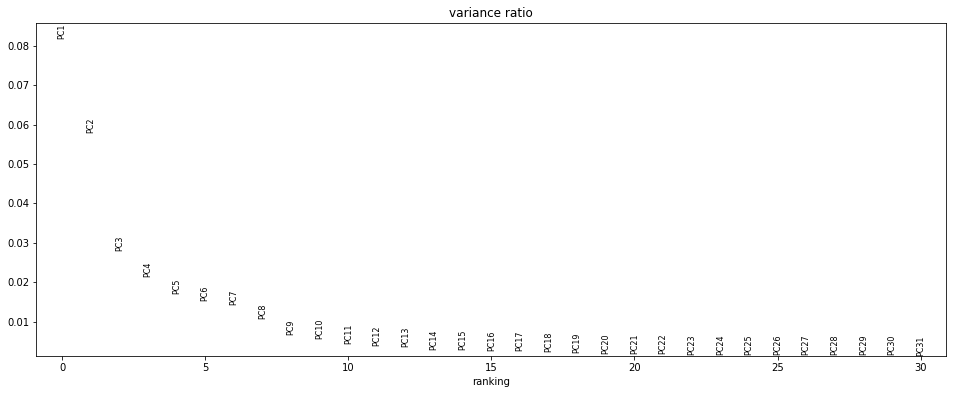

In [35]:
sc.plotting.pca_variance_ratio(adata)

You can plot any dimensionality reduction and colour cells by elements of `adata.obs` or by gene expression. Below we plot the three different samples composing the dataset, the total number of transcripts and the expression of SYCP1.

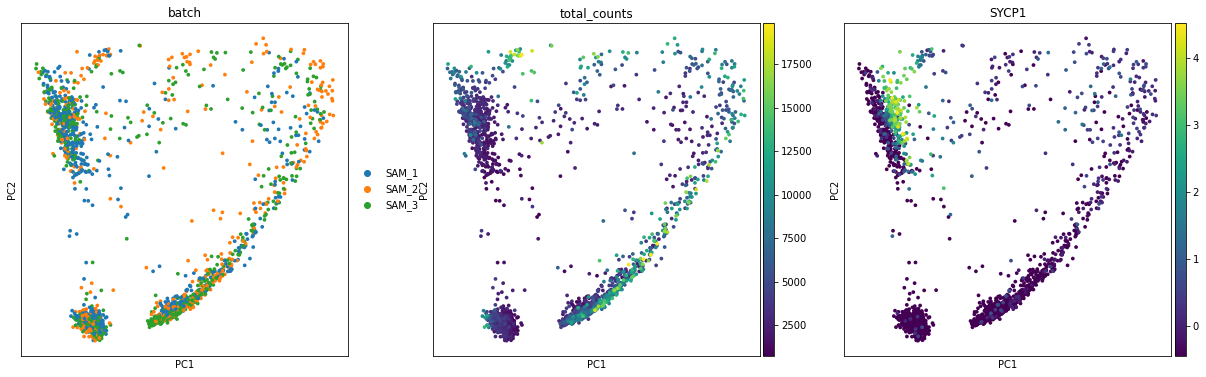

In [36]:
plt.rcParams['figure.figsize'] = (6,6) #reduce figure size
sc.pl.pca(adata, color=['batch','total_counts','SYCP1'])

### EXERCISE: What would happen without normalization?

Data normalization has proven essential to avoid technical properties of the dataset to dominate the data projections. Usually, the total number of transcripts per cell (and thus number of detected genes per cell because of their correlation) dominate one of the very first PCA dimension, dominating therefore the explained variance of the data and covering important biological signals.

Try to write down code for the following steps (template or hints are provided):

- Copy as primary matrix into `adata.X` the matrix we saved as `raw_counts` in `adata.layers`

In [37]:
# adata.X = ..............copy()
adata.X = adata.layers['raw_counts'].copy()

- calculate the PCA on the dataset using the same command as for the PCA for normalized data

In [38]:
# ....................
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)

- make a correlation plot using the package `seaborn` (shortened as `sns`) between each of the first three PCA dimensions and the `total_counts` column of ´adata.obs´, representing the number of transcripts per cell. You will see how the transcript per cell are very much correlated to the most important PCA dimension, probably hiding meaningful biological signal

<AxesSubplot:ylabel='total_counts'>

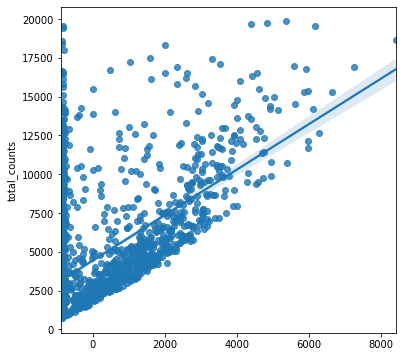

In [39]:
###### dimension 1: x is the first PCA dimension, y must be the total transcripts per cell
#
# sns.regplot(x = adata.obsm['X_pca'][:,0], y = .........)
sns.regplot(x = adata.obsm['X_pca'][:,0], y = adata.obs['total_counts'])

<AxesSubplot:ylabel='total_counts'>

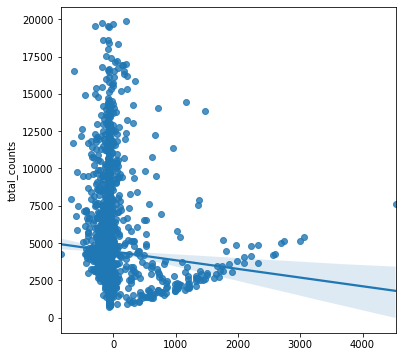

In [40]:
###### dimension 2
# 
sns.regplot(x = adata.obsm['X_pca'][:,1], y = adata.obs['total_counts'], )

<AxesSubplot:ylabel='total_counts'>

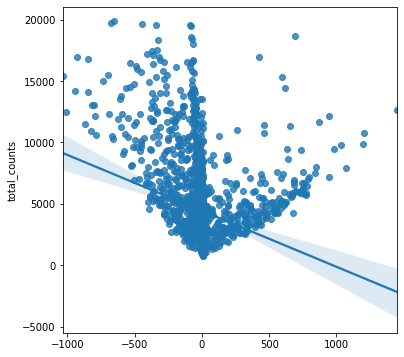

In [41]:
###### dimension 3
# 
sns.regplot(x = adata.obsm['X_pca'][:,2], y = adata.obs['total_counts'], )

- replicate the steps above to plot the regression line between the first PCA dimension and the total transcipts per cell, using the matrix of standardized data `gauss_counts`. You will see how the correlation with the PCA component is lost. This should prioritize the highlight of biological information and not of technical biases. 

Help: You need to make `adata.X` as the `gauss_counts` matrix, run again the PCA command and do the regression plot.

<AxesSubplot:ylabel='total_counts'>

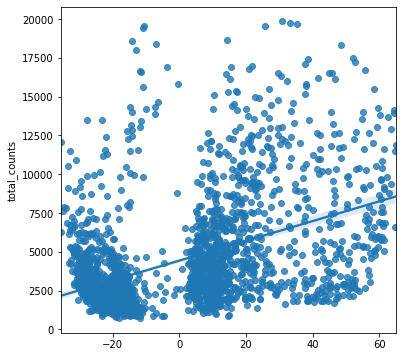

In [42]:
# ..................
#

adata.X = adata.layers['gauss_counts'].copy()

sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)

sns.regplot(x = adata.obsm['X_pca'][:,0], y = adata.obs['total_counts'])

### tSNE projection
Scanpy allows to project the data with two methods, *tSNE* and *UMAP*. They are both based on interpreting the data as a graph whose vertices are the cells. To run both methods, we have to calculate the *k-nearest neighbours* to each cell. To do this we can use `sc.preprocessing.neighbors`. One can also use the tool `bbknn` to calculate neighbors taking into account the different samples composing the datasets, as it is needed in our case. Note that we must choose the number of PC (Principal Components) of the PCA, since the algorithms are based on the PCA projection for efficiency purpose. 
tSNE requires the tuning of the perplexity (a parameter controlling the size of the neighbourhood of each point), while UMAP is more robust without tuning parameters.
Check these pages for more information on the two tools: [tSNE](https://distill.pub/2016/misread-tsne/) and [UMAP](https://umap-learn.readthedocs.io/en/latest/).

In [44]:
#calculate distances between cells and take samples into account
sc.external.pp.bbknn(adata, n_pcs=15, batch_key='batch', )

In [45]:
#perplexity is by default (30). Values between 5 and 50 are usually suggested for stability of the result.
sc.tools.tsne(adata, n_pcs=15, random_state=12345)

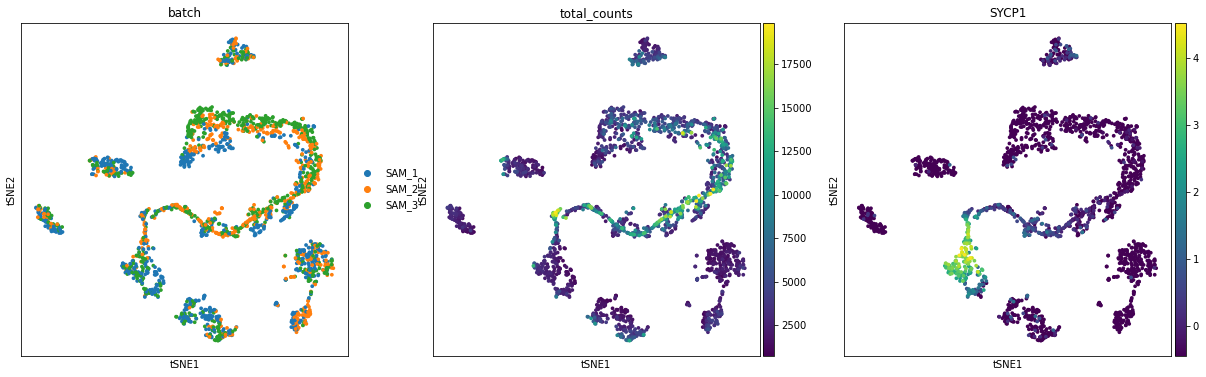

In [46]:
sc.plotting.tsne(adata, color=['batch','total_counts','SYCP1'])

### Exercise: tSNE perplexity and execution time

The tSNE plot can change considerably if we change the perplexity parameter, for example by adding `perplexity=5`. A smaller perplexity will consider the structure of a smaller 'area' close to each cell, with the drawback of partially losing the global structure of the biological process we are studying

Try some higher values of the perplexity up to 100. You can see how the plot seems more structured with some values rather than others.

In [47]:
# ......

sc.tools.tsne(adata, n_pcs=15, random_state=12345, perplexity=5)

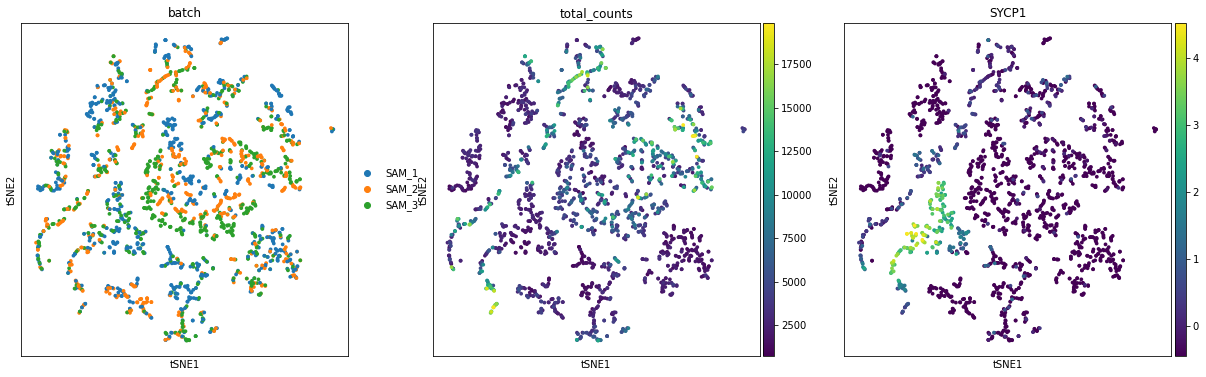

In [48]:
# ......

sc.plotting.tsne(adata, color=['batch','total_counts','SYCP1'])

In [49]:
# ......

sc.tools.tsne(adata, n_pcs=15, random_state=12345, perplexity=50)

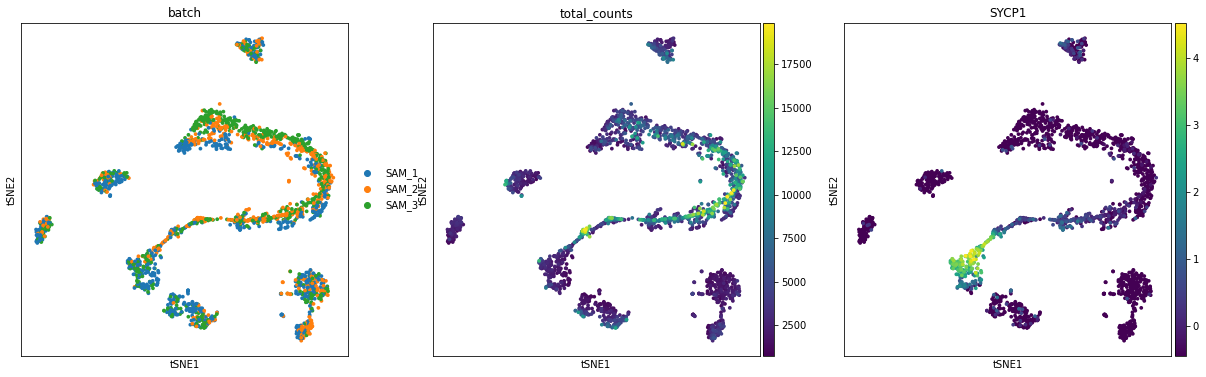

In [50]:
# ......

sc.plotting.tsne(adata, color=['batch','total_counts','SYCP1'])

Also, note that calling tSNE to calculate just two dimensions require quite some time. tSNE execution time scales indeed exponentially in the number of dimensions. Try to rerun tSne preceded by the `%timeit` command and choosing the perplexity value you prefere. You will get an average runtime value. Note: benchmarking takes some time.

In [58]:
# ........................

%timeit sc.tools.tsne(adata, n_pcs=15, random_state=12345, perplexity=50)

1 loop, best of 5: 14.4 s per loop


### UMAP projection

Many use UMAP in favour of tSNE. UMAP is another projection algorithm that finds the optimal formulation of the projection criteria according to some topological formulation. 

UMAP is structured in a way that calculations are faster than in tSNE and scale less than exponentially with the number of dimensions. 

Note the lower execution time compared to tSNE, even if we calculate 15 dimensions instead of 2, and also look at the "nicer" plot.

In [59]:
%timeit sc.tools.umap(adata, random_state=54321, n_components=10)

1 loop, best of 5: 7.59 s per loop


The plot is made for different pairs of dimensions (1,2 - 1,3 - 2,3 - 2,4), that give different perspectives over the dataset. You can observe how there are four clusters  separated from a main block of cells looking like a long "snake". Clic on the plot to zoom in.

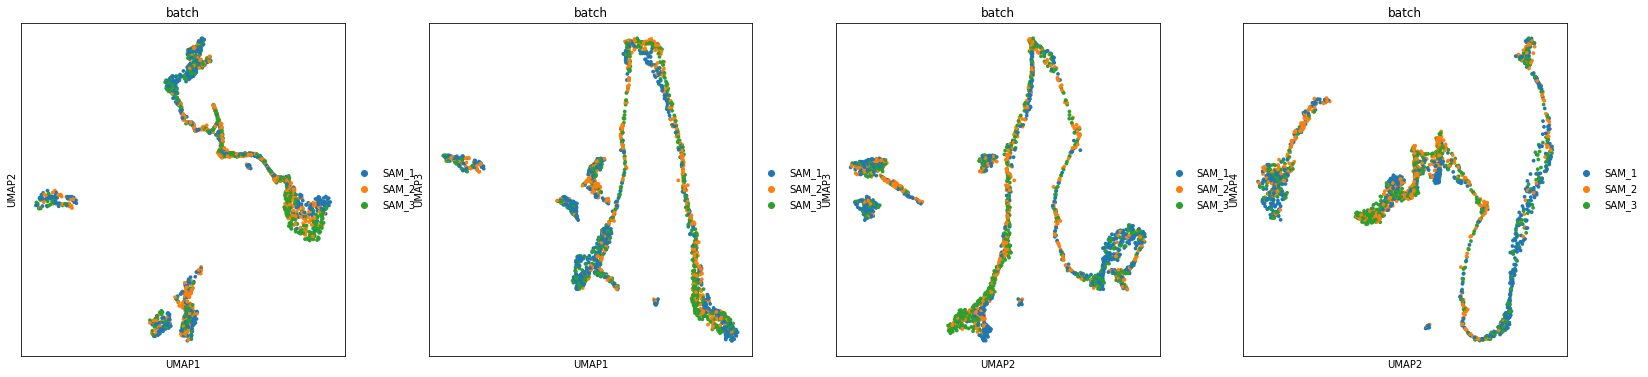

In [60]:
sc.plotting.umap(adata, color=['batch'], components=['1,2','1,3','2,3','2,4'])

The 3d plot over dimensions 1-3-4 2-3-4 gives a very good perspective over the projection and shows better the distance between the various clusters. The main group of cells seems twisting at least twice without overlapping, but we do not see any branching. This might mean that there is only one differentiation path.

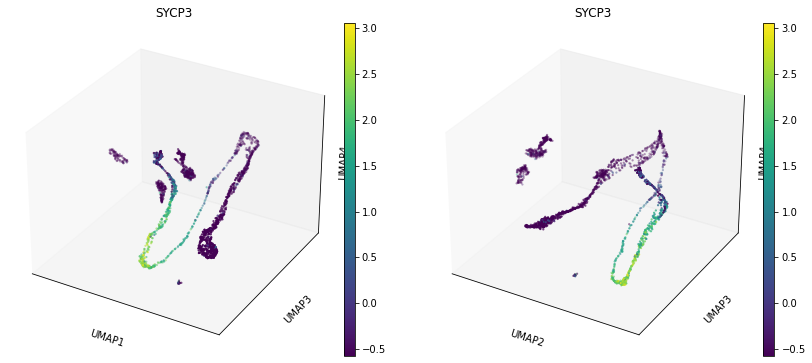

In [61]:
sc.plotting.umap(adata, color=['SYCP3'], projection='3d', components=['1,3,4','2,3,4'] )

## Clustering

Various clustering techniques are possible to identify similar cells. Note that, when identifying a cluster, we can assign that to a likely cell type by using for example known markers. 

However, be aware that clusters do not necessarily match perfectly cell types (especially if cells change in a continuous way, hard clusters are not be the best solution). 



In [62]:
#leiden clustering at various resolutions
sc.tools.leiden(adata, resolution=1, random_state=12345, key_added='leiden_R1')
sc.tools.leiden(adata, resolution=0.5, random_state=12345, key_added='leiden_R.5')
sc.tools.leiden(adata, resolution=0.25, random_state=12345, key_added='leiden_R.25')
sc.tools.leiden(adata, resolution=0.1, random_state=12345, key_added='leiden_R.1')

### Leiden algorithm 

Scanpy contains the *leiden* approach, making clusters whose points are well connected and at the same time mostly disconnected from other clusters. Other approaches, e.g. *k-means*, can be performed on the data or on its PCA/tSNE/UMAP projection.

While *leiden* requires to specify a resolution parameters influencing the number of clusters, other algorithms such as *k-means* require directly the number of desired clusters.

We can see that at resolution 1 we have many clusters, and their number decreases with decreasing resolution. A way to choose how many cluster to keep, is to look at how correlated they are in the correlation matrix. Many correlated clusters might just be matching cell types, and they could be merged into one cluster.

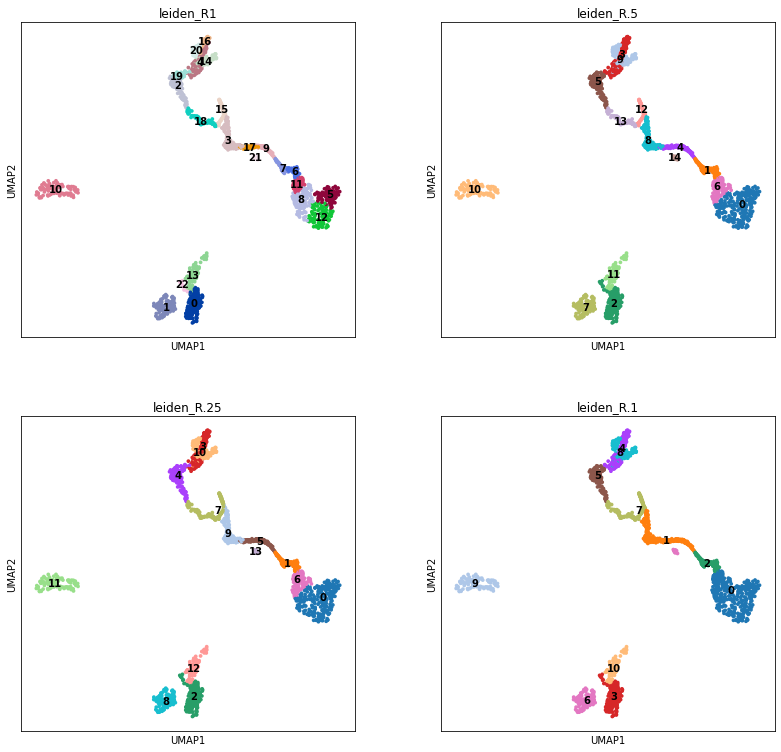

In [63]:
sc.plotting.umap(adata, color=['leiden_R1','leiden_R.5','leiden_R.25', 'leiden_R.1'], 
                 legend_loc='on data', ncols=2)

Let's look at correlation matrices and at how many clusters are very correlated (let's say with correlation above a threshold of 0.8). If we plot correlation matrices starting from resolution 0.1, we can notice that at resolution 0.25 there are blocks of very correlated clusters. However, for resolution 0.25, only two correlations are above 0.8, and we can detect a tiny cluster lost at resolution 0.1. Higher resolutions show instead too many blocks of correlated clusters

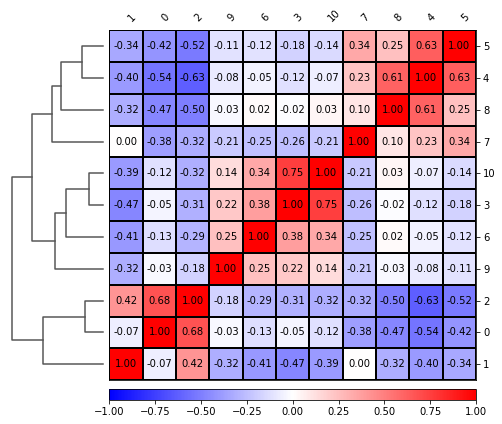

In [64]:
sc.pl.correlation_matrix(adata, 'leiden_R.1', show_correlation_numbers=True)

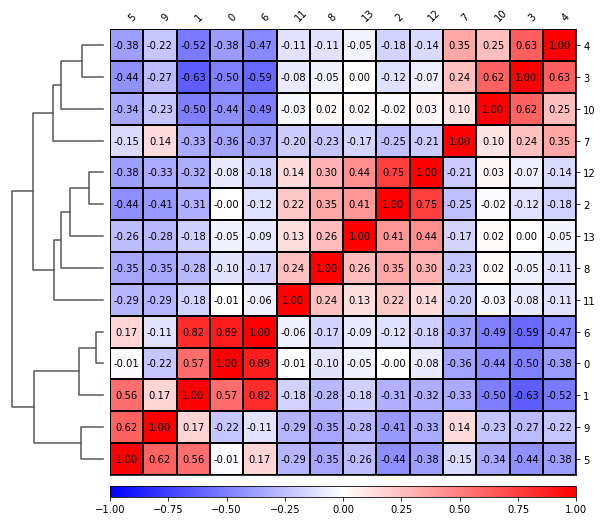

In [65]:
sc.pl.correlation_matrix(adata, 'leiden_R.25', show_correlation_numbers=True)

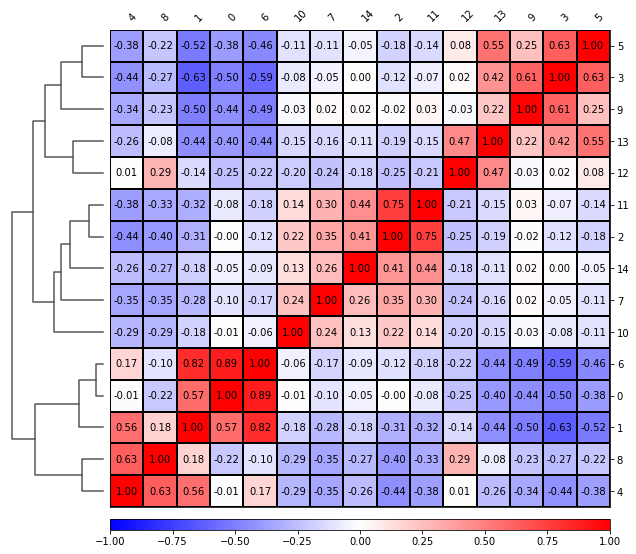

In [66]:
sc.pl.correlation_matrix(adata, 'leiden_R.5', show_correlation_numbers=True)

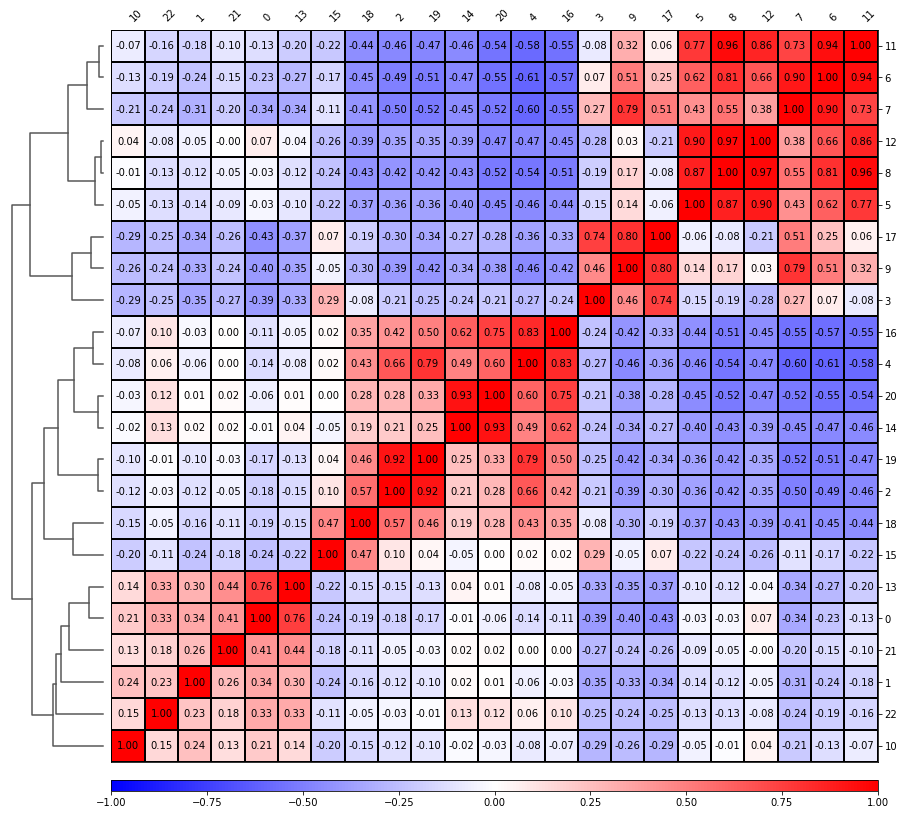

In [67]:
sc.pl.correlation_matrix(adata, 'leiden_R1', show_correlation_numbers=True)

Using the correlation as a measure for evaluating clustering is motivated by the fact that it captures the changes in gene expression between clusters. We can use other methods based on the euclidean distance to calculate a score for the clustering resolutions. 

One method could be the well-known [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20value%20is%20a,poorly%20matched%20to%20neighboring%20clusters.). This calculates a score for each cluster based on how close cells are to each other. However, our data is highly non linear, and the silhouette score is based on a distance that works better on linear datasets. 

To speed up calculations, we use the first 15 dimensions of the PCA projection as a proxy for the whole dataset.
Here we have the resolutions 0.1 scoring best, and we choose it as clustering with the leiden algorithm. Resolution 0.25 seemed also a good candidate, but to avoid having many clusters to handle with in this exercise, we keep 0.1.

In [68]:
import sklearn.metrics as METRICS

score_R1 = METRICS.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                            np.asarray(adata.obs['leiden_R1']) )
score_R0_5 = METRICS.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                              np.asarray(adata.obs['leiden_R.5']) )
score_R0_25 = METRICS.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                               np.asarray(adata.obs['leiden_R.25']) )
score_R0_1 = METRICS.silhouette_score( adata.obsm['X_pca'][:,0:15], 
                                              np.asarray(adata.obs['leiden_R.1']) )
print('Silhouette score at resolution')
print('R=1\t   R=0.5\tR=0.25\t  R=0.1')
print(score_R1, score_R0_5, score_R0_25, score_R0_1)

Silhouette score at resolution
R=1	   R=0.5	R=0.25	  R=0.1
0.36728227 0.4674247 0.4558696 0.47929615


### k-means algorithm
An alternative type of clustering is given by the k-means. This can be based on many different distances (for example euclidean) to determine which cells are closest to each other and pertain to a cluster. The python implementation of the library `sklearn` uses only the euclidean distance. 

Let's make as many clusters as for the resolution of choice with the leiden algorithm (you should have 11 clusters). We apply k-means to the UMAP projection, considering it a good low-dimensional proxy of our data.

In [69]:
from sklearn.cluster import KMeans

N=11
kmeans_obj = KMeans(n_clusters=N, random_state=12345)
kmeans_clusters = kmeans_obj.fit_predict(adata.obsm['X_umap'])
adata.obs[f'kmeans_{N}'] = pd.Categorical(kmeans_clusters)

There is quite a visible match for the clusters in the UMAP plots, apart from few splits in different places. Some cell types might be split or merged in the wrong way, so we want to choose a good clustering matching cell types as much as possible.

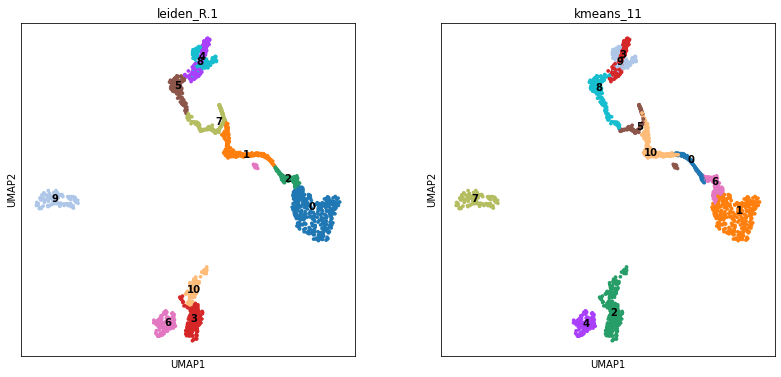

In [70]:
sc.plotting.umap(adata, color=['leiden_R.1',f'kmeans_{N}'], 
                 legend_loc='on data')

Look at the correlation matrices for another comparison of the two clusterings.

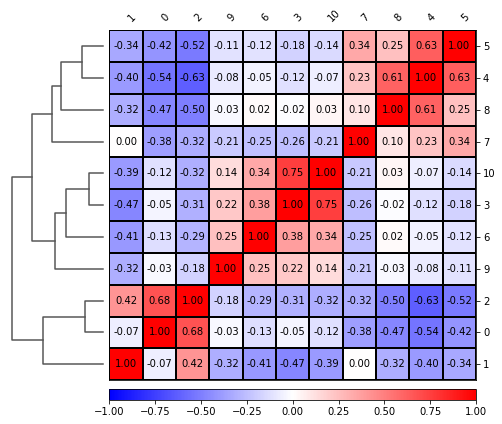

In [71]:
sc.pl.correlation_matrix(adata, 'leiden_R.1', show_correlation_numbers=True)

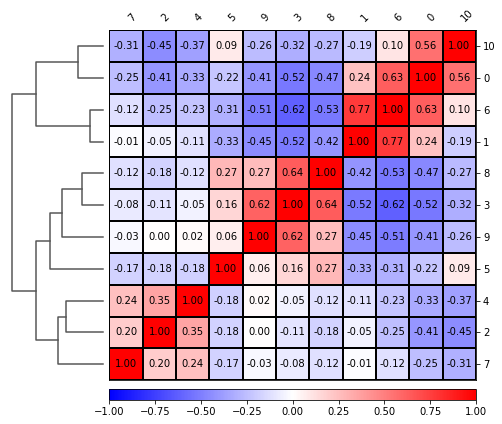

In [72]:
sc.pl.correlation_matrix(adata, f'kmeans_{N}', show_correlation_numbers=True)

You will see that the two dendrograms on the left side of the matrices appear very similar, as well as the correlation values in the matrix do not change too much. This is confirmed if we look at the median correlations of the two matrices. 

In [73]:
corr_leiden = pd.DataFrame(adata.uns['dendrogram_leiden_R.1']['correlation_matrix'],
             index=adata.uns['dendrogram_leiden_R.1']['categories_idx_ordered'],
             columns=adata.uns['dendrogram_leiden_R.1']['categories_idx_ordered'])
corr_kmeans = pd.DataFrame(adata.uns['dendrogram_kmeans_11']['correlation_matrix'],
             index=adata.uns['dendrogram_kmeans_11']['categories_idx_ordered'],
             columns=adata.uns['dendrogram_kmeans_11']['categories_idx_ordered'])

In [74]:
print('average correlation Leiden', np.median( np.triu( corr_leiden,1 )[np.triu( corr_leiden,1 )>0]  ))

average correlation Leiden 0.24980534297517126


In [75]:
print('median correlation kmeans', np.median( np.triu( corr_kmeans,1 )[np.triu( corr_kmeans,1 )>0]  ))

median correlation kmeans 0.24442178011418325


The same holds for the silhouette score, that gives you a score for how the clusters are well separated. Note: the k-means might have a higher score than the leiden algorithm, since both k-means and silhouette score are based on the euclidean distance and misses the non linear structure of the data.

In [76]:
score_kmeans = sklearn.metrics.silhouette_score( adata.obsm['X_umap'], 
                                            np.asarray(adata.obs['kmeans_11']) )
score_leiden = sklearn.metrics.silhouette_score( adata.obsm['X_umap'], 
                                            np.asarray(adata.obs['leiden_R.1']) )

print('Silhouette score for kmeans with 11 clusters', score_kmeans, 'and Leiden with R=.1', score_leiden)

Silhouette score for kmeans with 11 clusters 0.59697723 and Leiden with R=.1 0.5823881


### Clustering choice

Right now it is hard to discern between the two clusterings. A good criteria to verify how good the clustering is, consists in checking where type-specific genes are expressed. We make a python dictionary including some cell types and a few of their marker genes, and then we plot those on the UMAP plot to compare expression patterns and clusters.

A dictionary is a python object in which you can allocate different objects (matrices, vectors, ...), each having an assigned name. Here, we save lists of marker genes, where each list is identified by the name of the corresponding cell type. To remember the different stages of spermatogenesis, a [scheme](http://www.embryology.ch/dutch/cgametogen/spermato03.html) is attached below

![fig](http://www.embryology.ch/images/cimggametogen/03spermato/c3e_spermatogenese.gif)

In [77]:
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4']
markers['Spermatogonia B'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['VIM','CTSL']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']

Let's plot the two clusterings again for reference. We plot a couple of projections to have more than one point of view. Try to plot other dimensions if you want to play around with those.

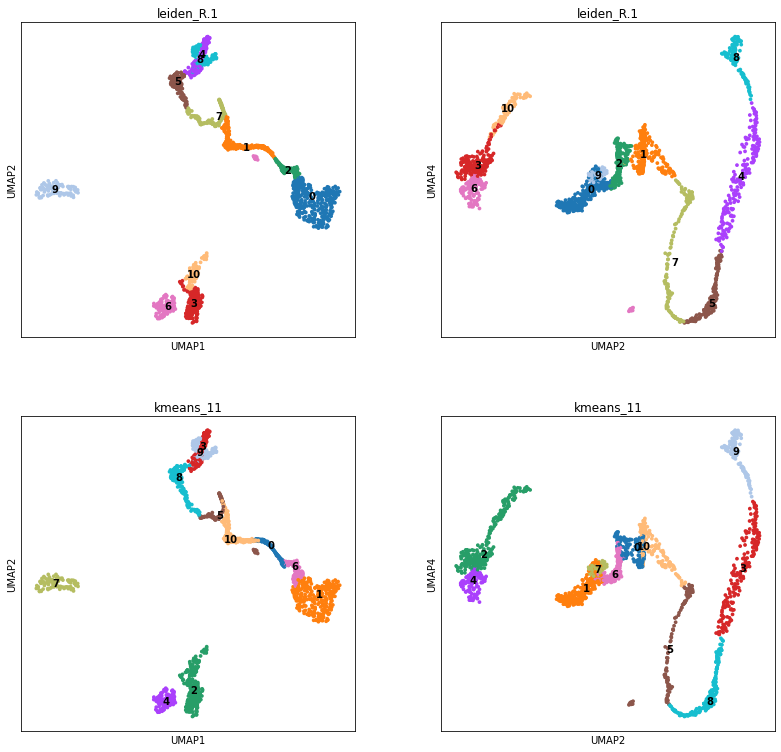

In [81]:
sc.plotting.umap(adata, color=['leiden_R.1','kmeans_11'], legend_loc='on data', components=['1,2','2,4'], ncols=2)

Make a separate UMAP plot for every cell type. You should be able to see quite clearly some clusters where the marker's expressions are stronger.

Plot `SpermatogoniaA`. here the cluster is pretty clear.

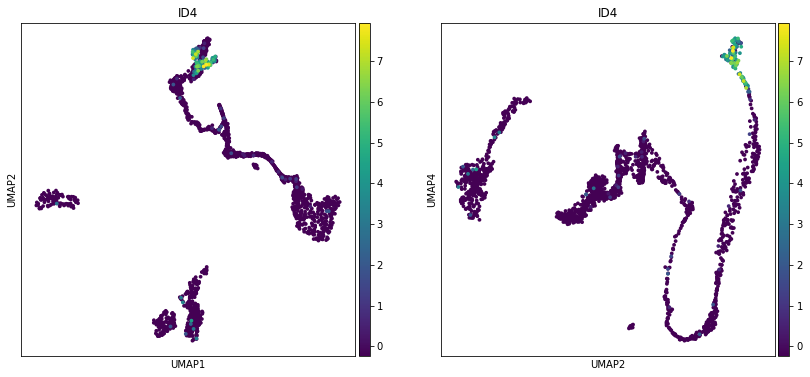

In [83]:
# .......

sc.plotting.umap(adata, color=markers['SpermatogoniaA'], 
                 components=['1,2','2,4'])

Plot `SpermatogoniaB` - this include also the marker `MKI67` for mitosis.

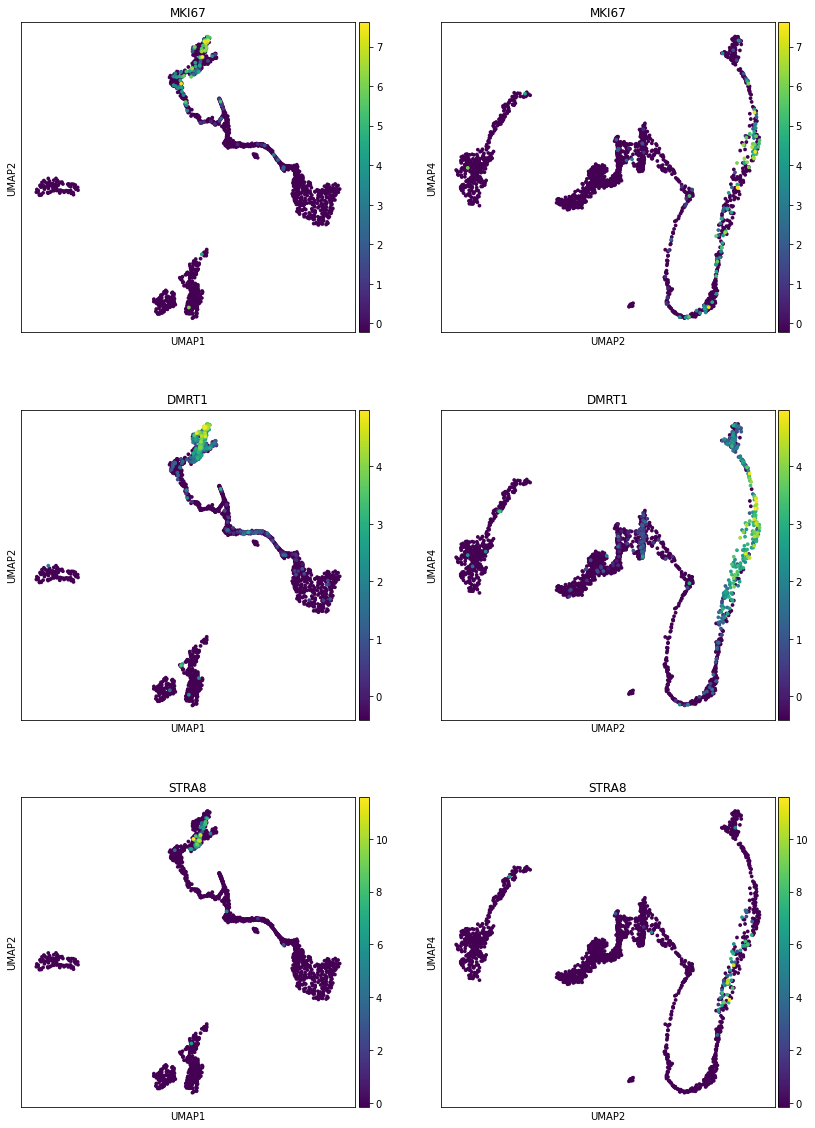

In [86]:
# .......

sc.plotting.umap(adata, color=markers['Spermatogonia B'], legend_loc='on data', ncols=2, components=['1,2','2,4'])

Plot `SpermatocytesI`. `SpermatocytesI` arise from `SpermatogoniaB` after a 24-days meiosis. Many of its markers are very specific, such as `MEIOB`, while others like `PRSS50` are transcribed very early because they pertain to the very first stage that transitions `SpermatogoniaB` cells into the meiotic process (Leptotene). The other genes come at a later stage of meiosis (Zygotene). 

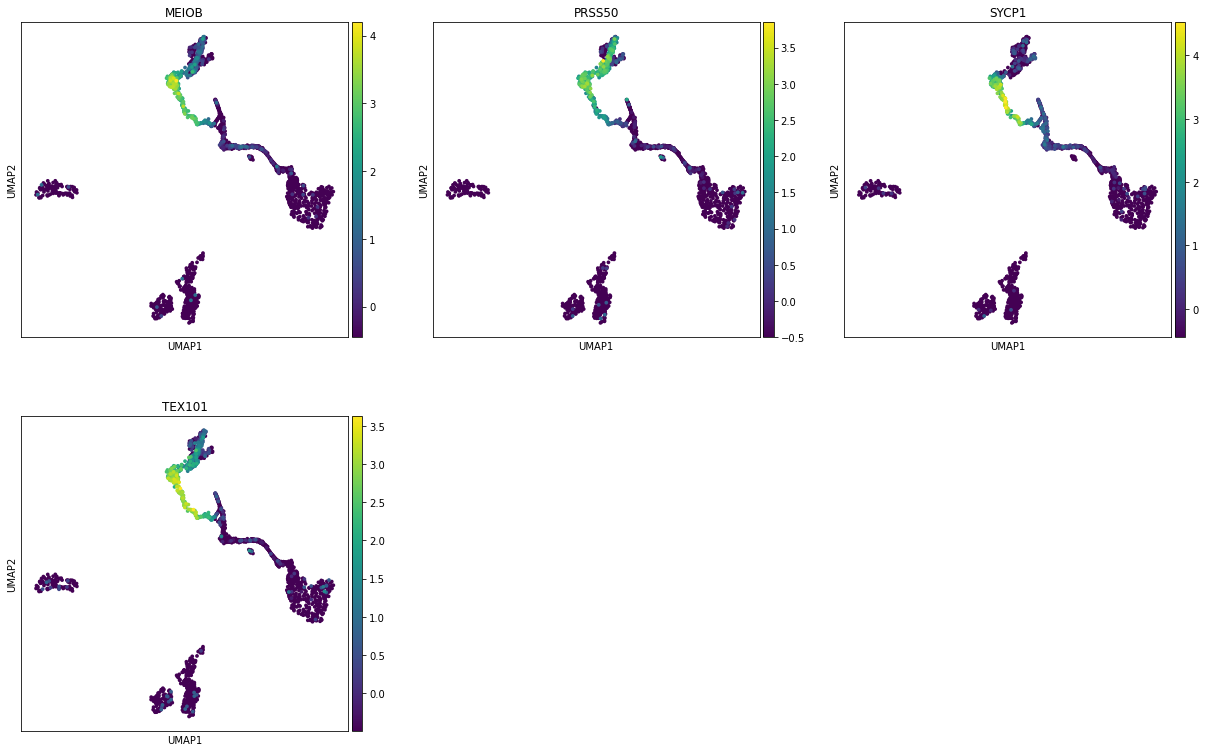

In [87]:
# .......

sc.plotting.umap(adata, color=markers['SpermatocytesI'], legend_loc='on data', ncols=3)

Plot `SpermatocytesII`. Here we can see marker genes for the final meiosis stage (Zygotene) and the mature spermatocytes. `ACRV1` is associated both with mature spermatocytes and Round spermatids.

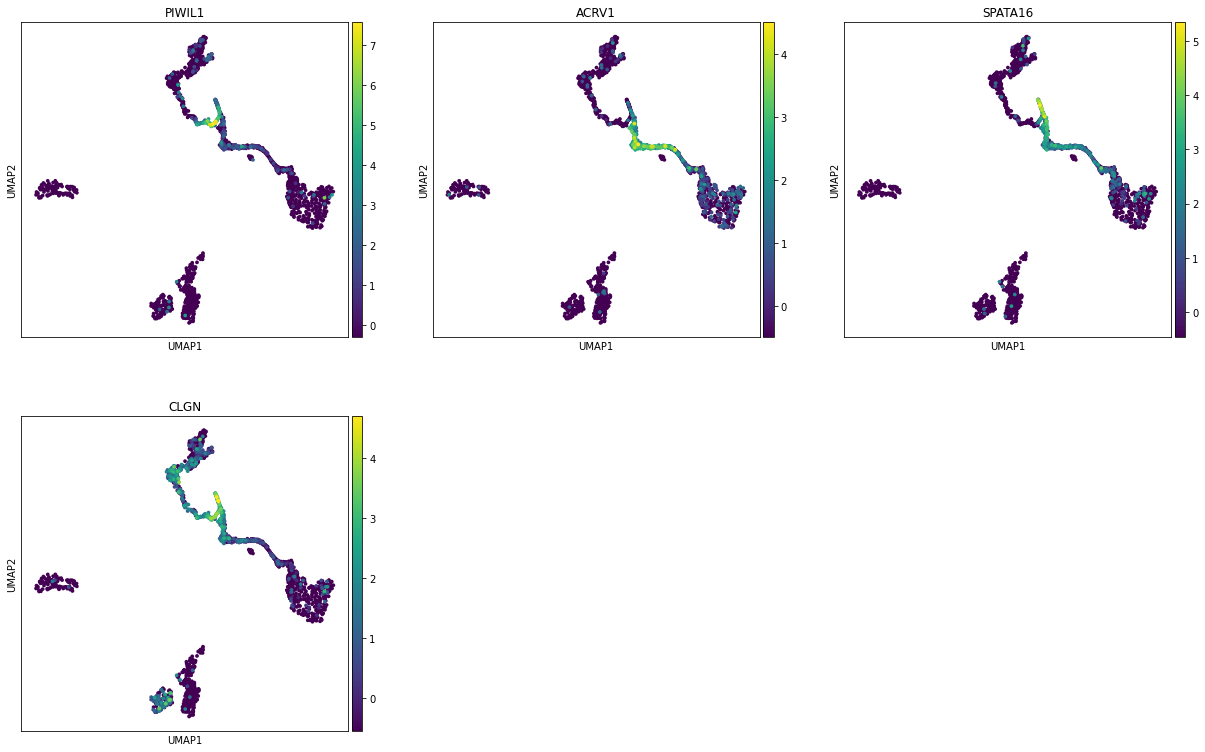

In [88]:
sc.plotting.umap(adata, color=markers['SpermatocytesII'], legend_loc='on data', ncols=3)

Plot `Round spermatids` (cells that still have to assume the final elongated shape of spermatozoa). The patterns are a bit less clear, and that is because many markers are often also expressed in the latest stage of spermatids. However, we can still see there are areas with higher values of the markers compared to others.

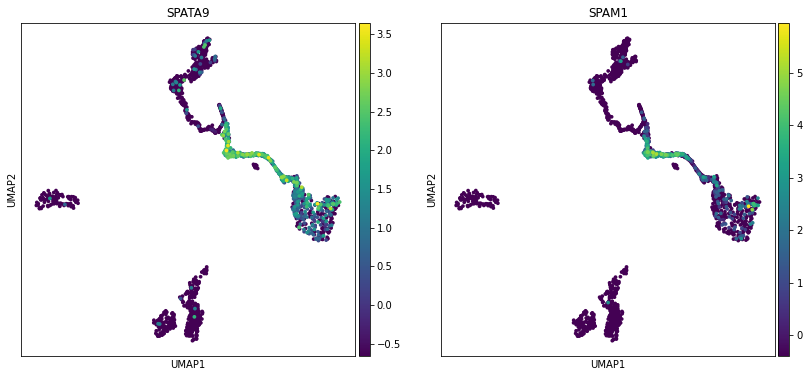

In [89]:
sc.plotting.umap(adata, color=markers['Round.Spt'], legend_loc='on data', ncols=3)

Plot `Elongated spermatids`. Again the patterns have some overlapping with the round spermatids.

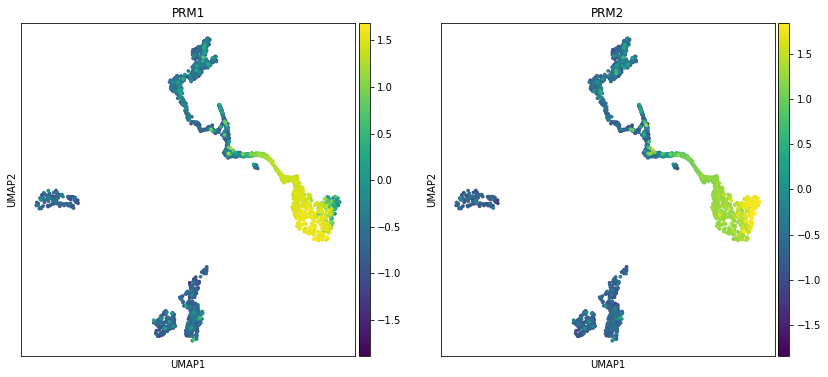

In [90]:
sc.plotting.umap(adata, color=markers['Elong.Spt'], legend_loc='on data', ncols=3)

Plot `Myoid`. Note that myoid genes are mostly expressed in a subcluster detected only by the Leiden algorithm.

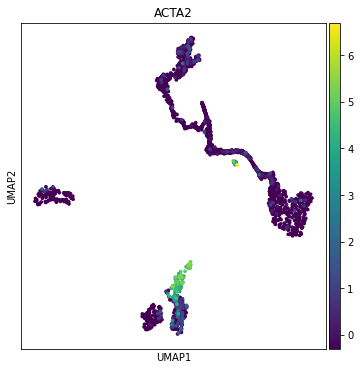

In [91]:
sc.plotting.umap(adata, color=markers['Myoid'], legend_loc='on data', ncols=3)

Plot `Macrophage`

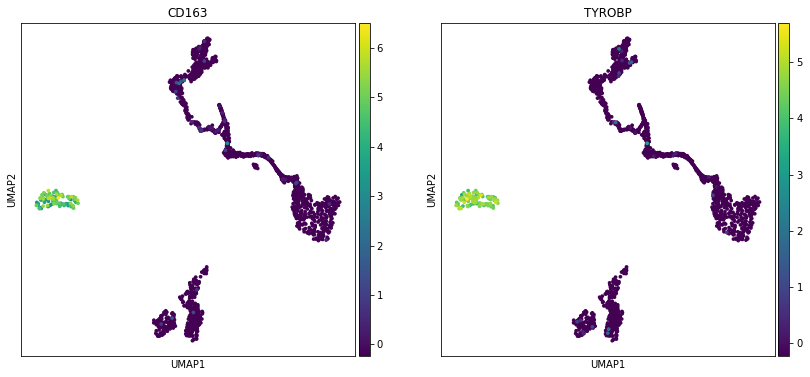

In [92]:
sc.plotting.umap(adata, color=markers['Macroph'], legend_loc='on data', ncols=3)

Plot `Leydig`. Here we can see again that we can distinguish Leydig cells from Myoid

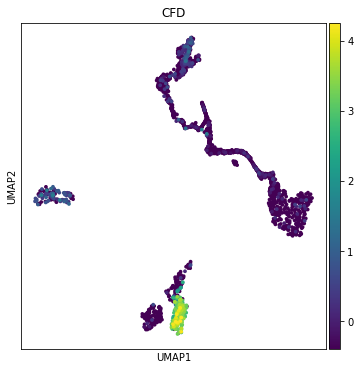

In [93]:
sc.plotting.umap(adata, color=markers['Leydig'], legend_loc='on data', ncols=3)

plot `Endothelial`. Here it is a bit harder to detect the right cluster, but it should be possible to spot it

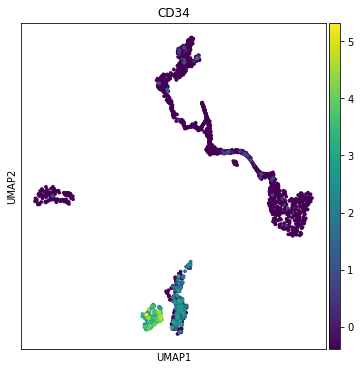

In [94]:
sc.plotting.umap(adata, color=markers['Endothelial'], legend_loc='on data', ncols=3)

Plot `Sertoli`. Identifying sertoli cells it is usually a difficult task. Often, sertoli cells are not captured in microdroplet methods, since they have a rather large size compared to other cells and to the droplet themselves. Moreover, Sertoli markers are often expressed in the other germ and somatic cells as well, making an eventual identification hard. In our case, it does not seem possible to identify reliably a Sertoli cluster.

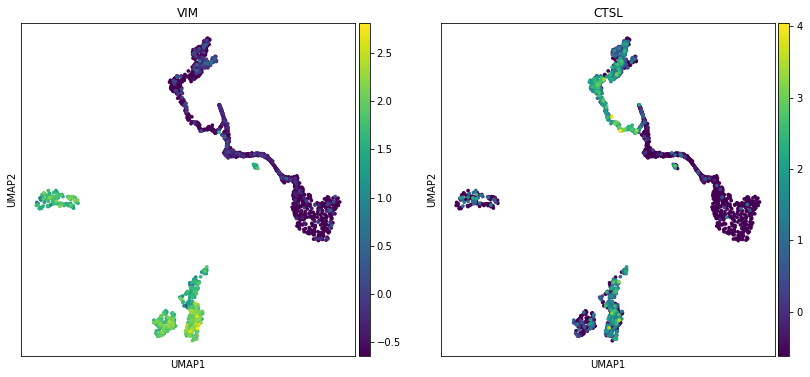

In [95]:
sc.plotting.umap(adata, color=markers['Sertoli'], legend_loc='on data', ncols=3)

**Question:** given the markers plot and the match of somatic markers with clusters, would you choose the clustering with the k-means or the Leiden algorithm?

### Cluster assignment
Defining the most likely cell type present in a cluster is sometimes a very complicated task, especially in big datasets where the cells change from one type to another in a very continuous fashion, making the "hard clustering" not a completely realistic model. Some methods allow "implicitely" to assign cell types: this is for example possible by using the tool SDA (external tool not implemented in python), that identifies modules of relevant marker genes and assigns them a score for each cell in the dataset. 

In this way, knowing relevant markers for cell types, it is possible to use thos scores as a "smooth" cell type assignment. Another possibility is to use supervised classifiers trained on curated single cell atlases.


However, for many applications, a hard clustering associated with a careful markers analysis is a well-accepted technique in the scientific community, and is used in basically the totality of the state-of-the-art publications.

We have already observed marker genes on UMAP plots. According to marker genes, it seems the Leiden algorithm is the best one, so we are going to look into it from now on. 

To better support the cluster identification from a statistical point of view, we can calculate the differential gene expression. This is necessary if you want to make a sound argument in a publication or report. 

A standard way to do it, is to test if each gene has mean expression higher in a cluster than in all the others. Scanpy does that by using a t-test or the wilcoxon test. While the t-test is less powerful, the wilcoxon test is not best behaved with very sparse data. Let's simply apply the default t-test to the dataset.

Note that, for the standard t-test in scanpy, you need to use logarithmized data. Fortunately, this is saved in one of the layers we made earlier, and can be assigned to `adata.X`

In [96]:
#Perform the test
adata.X = adata.layers['log_counts'].copy()
sc.tl.rank_genes_groups(adata, groupby='leiden_R.1')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We can plot the most differentially expressed genes of each cluster after testing. Genes are ordered by score, a measure related to their mean expression in the cluster. For some clusters it is immediately clear the identity. Clusters 0 and 1 express PRM2 and TNP1, known markers of elongated spermatids. Cluster 5 shows ZCWPW1, a marker for cells undergoing meiosis, and so on for other clusters.

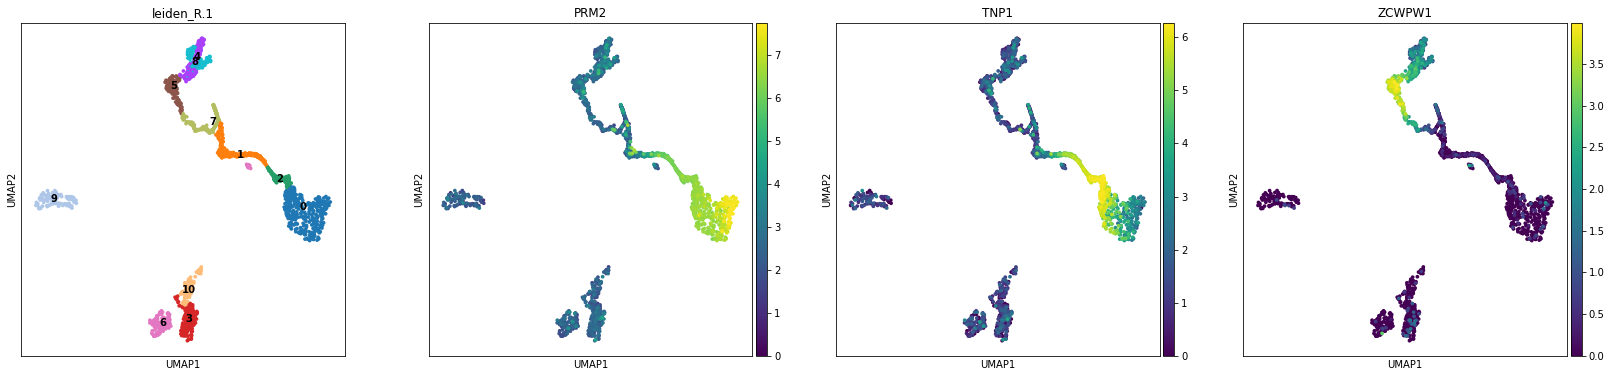

In [97]:
sc.plotting.umap(adata, color=['leiden_R.1','PRM2','TNP1','ZCWPW1'], legend_loc='on data', ncols=4)

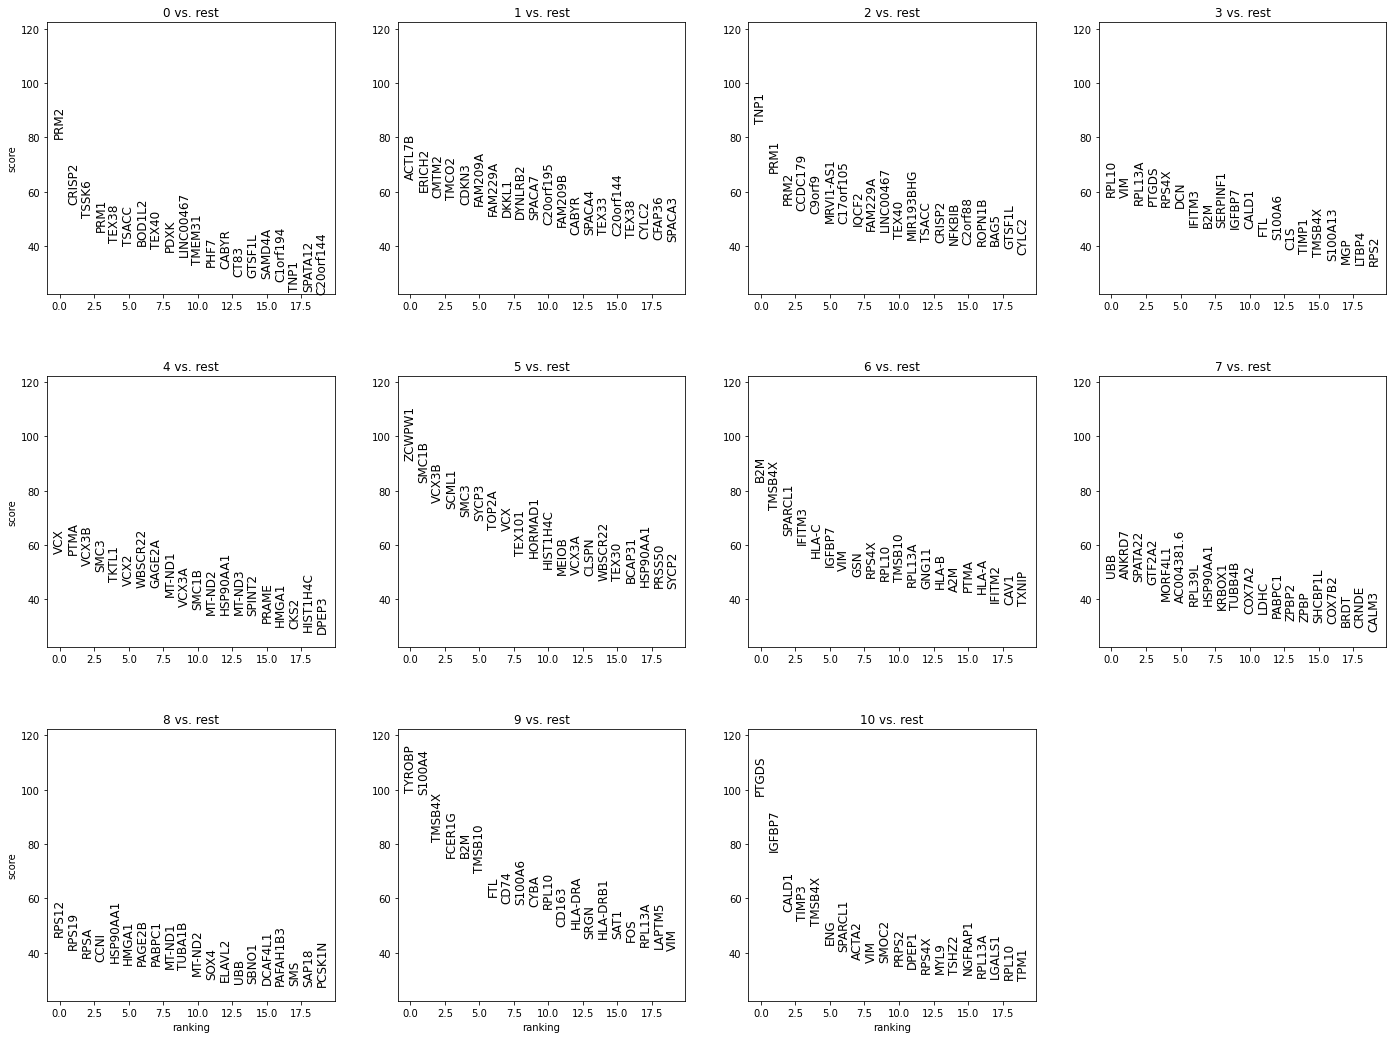

In [98]:
#plot the test results
sc.pl.rank_genes_groups(adata, groupby='leiden_R.1', fontsize=12)

Dotplots can again give a very good overview of the gene expressions, as well as heatmaps do

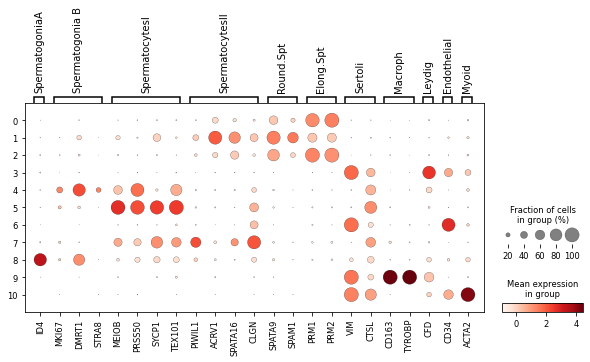

In [99]:
sc.pl.dotplot(adata, groupby='leiden_R.1', var_names=markers, smallest_dot=.35, layer='gauss_counts')

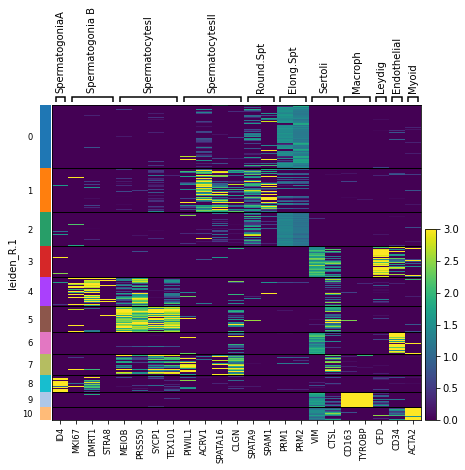

In [100]:
sc.pl.heatmap(adata, groupby='leiden_R.1', var_names=markers, layer='gauss_counts', vmin=0, vmax=3)

**Exercise**: 

We now rename the categories we found in our observations about clusters - remember that we excluded Sertoli cells. Some cluster can be named the same and will be merged. Write the names of the clusters in the list `names` (an example of name of the first cluster is written) by looking at the dotplot and/or heatmap above, and at the UMAP plot. If two clusters seem to overlap a lot, just use the name of one of the two, or make up a name that is a combination of the two. If you use a name more than once, write its name followed by '_' and a number or letter.

In [110]:
adata.obs['leiden_R.1'].cat.categories #the cluster numbers

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')

In [111]:
# names = ['Elong.Spt_1', ...............]
names = ['Elong.Spt_1', 'SpcII.RSpt', 'Elong.Spt_2',  'Leydig', 'SpermatogoniaB',
                                       'SpermatocytesI_1', 'Endothelial', 'SpermatocytesI_2',
                                       'SpermatogoniaA', 'Macrophages', 'Myoid']

In [112]:
adata.obs['clustering'] = adata.obs['leiden_R.1'].copy() #copy cluster vector with numbers
adata.rename_categories('clustering', names)

We merge the clusters with same names. This cannot be done with a *categorical* object, where categories cannot have the same name. We convert the cluster names into a simple *array* to do this, and then reconvert it to a categorical object.

In [113]:
clustering = np.array( adata.obs['clustering'] )
clustering = [np.str.split(i, '_')[0] for i in clustering] #split by character _ and take the first part (the name of the cell type)
adata.obs['clustering'] = pd.Categorical(clustering)

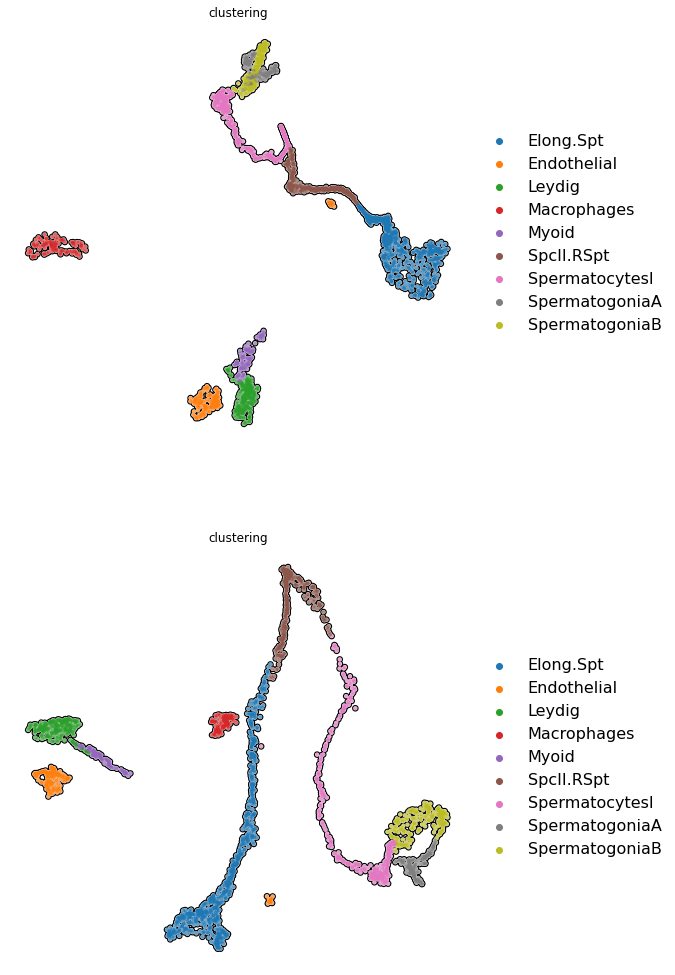

In [114]:
plt.rcParams['figure.figsize'] = (8,8)
sc.pl.umap( adata, color=['clustering'], 
           legend_loc='right margin', 
           legend_fontsize=16,
           frameon=False,
           size=60,
           add_outline=True,
           components=['1,2','2,3']  ,
           ncols=1  
           )

##Pseudotimes and cell fates

It is possible to calculate the distance of each cell from the origin of a biological process. This distance - called pseudotime - is used to order the cells in the biological process. Moreover, it is possible to simulate differentiation paths between cells to extrapolate the cells most likely to be representative of different cellular fates. To find cell fates, we combine the packages *palantir* and the tool *PAGA* of `scanpy`. Similar packages to perform this kind of analysis are *Monocle3* (R package) and *destiny*.
Such analysis is usually applied to a continuous differentiation process, therefore we subset the data to include only germ cells.

In [115]:
#subset the data
germData = adata[ [ i not in ['Endothelial', 'Myoid', 'Macrophages', 'Leydig'] for i in adata.obs['clustering'] ] ].copy()

In [116]:
germData

AnnData object with n_obs × n_vars = 1584 × 7394
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'perc_mito', 'n_genes', 'n_counts', 'leiden_R1', 'leiden_R.5', 'leiden_R.25', 'leiden_R.1', 'kmeans_11', 'clustering'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'batch_colors', 'neighbors', 'umap', 'leiden', 'leiden_R1_colors', 'leiden_R.5_colors', 'leiden_R.25_colors', 'leiden_R.1_colors', 'dendrogram_leiden_R.1', 'dendrogram_leiden_R.25', 'dendrogram_leiden_R.5', 'dendrogram_leiden_R1', 'kmeans_11_colors', 'dendrogram_kmeans_11', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'tpm_counts', 'log_counts', 'gauss_counts'
    obsp:

In [117]:
print(f'the data contains now {germData.shape[0]} cells and the germ cells of interest')

the data contains now 1584 cells and the germ cells of interest


We import *palantir* and define as data matrix for the analysis the logarithmized count matrix. We assign as *index* (row names) the cell barcodes, and as *columns* (columns names) the gene symbols.

In [118]:
import palantir
palantir.core.random.seed( a=12345 ) #define random seed

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [119]:
palantir_data = pd.DataFrame(germData.layers['log_counts'].todense(),
                             index=germData.obs_names,
                             columns=germData.var_names)

We recalculate PCA after removing the noisy datapoint and assign the calculated PCA to `palantir`

In [120]:
sc.preprocessing.pca(germData, random_state=12345, n_comps=15)
pca_projections = pd.DataFrame( germData.obsm['X_pca'].copy(),
                                index=germData.obs_names )     
## below if you want to calculate 300 PCA components from palantir
# pca_projections, _ = palantir.utils.run_pca(palantir_data, use_hvg=False)
# pca_projections.index = germData.obs_names

Here, we calculate the diffusion maps. A diffusion map is defined with a probabilistic process that create a "random path" between cells that are likely to be similar. From the diffusion map, `palantir` is able to detect different cell fates by calculating an underlying graph structure. The graph is assigned a root by the user, in this case a random cell of type SpermatogoniaA, the beginning of the spermatogenic process.

In [121]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10) #diffusion maps
ms_data = palantir.utils.determine_multiscale_space(dm_res) #multiscale space
start_cell = str(germData[germData.obs['clustering'] == 'SpermatogoniaA'].obs_names[1]) #root
pr_res = palantir.core.run_palantir( ms_data, early_cell=start_cell, num_waypoints=1000) #fate detection

Determing nearest neighbor graph...
Sampling and flocking waypoints...
Time for determining waypoints: 0.0045487403869628905 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.121858016649882 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Since we already calculated the UMAP projection, we extract that from the *germData* object instead of calculating the *tSNE* coordinates with *palantir*. We will see that the plot done from palantir matches our previous UMAP plots.

In [122]:
ms_data.index = germData.obs_names
projection = pd.DataFrame(germData.obsm['X_umap'][:,0:2],
                          index=germData.obs_names,
                          columns=['x','y'])

The algorithm provides the potential cell fates, represented by the cells most likely to be the end of those processes. Usually, there is only one fate for the mature spermatids that will provide spermatozoa. Sometimes it is possible to detect another fate, probably indicating some of the SpermatogoniaA not differentiating.

In [125]:
end_states = np.asarray(pr_res.branch_probs.columns)

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:>)

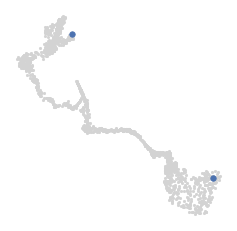

In [126]:
palantir.plot.highlight_cells_on_tsne(projection, end_states)

We now extract pseudotimes from `palantir`. The pseudotimes are used to give a timeline to the differentiation process, knowing its starting point (that we assigned before to `palantir`). Differentiation ends at the highest pseudotime values.

In [127]:
germData.obs['palantir_pseudotime'] = pr_res.pseudotime

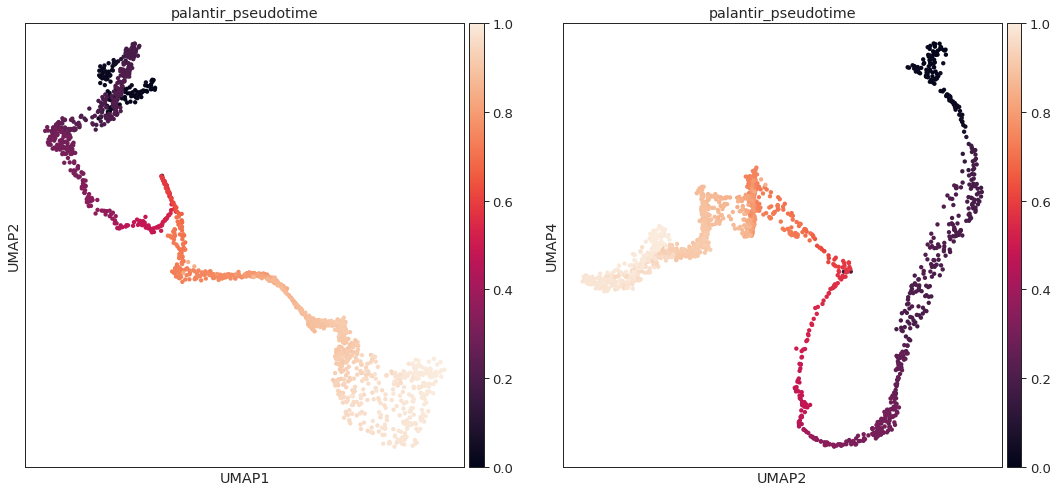

In [129]:
sc.pl.umap( germData, color=['palantir_pseudotime'], 
           legend_loc='on data', 
           legend_fontsize=16,
           ncols=2,
           components=['1,2','2,4'])